# Demo: Generate CCF Atlas Contour Image Slices

Use ITK to convert the Allen Mouse Brain Common Coordinate Framework (CCF) atlas label image to show only the boundary contours separating label regions. Results are written out both as a 3D image and as evenly spaced 2D slices given a direction and spacing.

### Inputs

- The CCF mouse brain atlas label image.
- Specification for slicing physical direction and step size.

### Outputs

- 3D contour image with contour intensities from `itk.LabelContourImageFilter`
- 3D binary contour image
- Series of 2D slices through the 3D binary contour image at given step size and offset

## See Also

CodeOcean capsule: https://codeocean.allenneuraldynamics.org/capsule/0748681/tree/v1


In [1]:
import os

import itk
import itkwidgets
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
CCF_ATLAS_LABEL_IMAGE_FILEPATH = (
    "../data/allen_mouse_ccf/annotation/ccf_2017/annotation_25.nii.gz"
)

RESULTS_PATH = "../results/ccf_contours"

In [3]:
SLICE_STEP_SIZE = 0.1  # mm
SLICE_PHYSICAL_AXIS = 0  # enumerated axis (0,1,2)

## Create 3D Contour Image

We use `itk.label_contour_image_filter` and `itk.binary_threshold_image_filter`
to construct a binary image with boundaries between regions represented with uniform intensity.

In [4]:
label_image = itk.imread(CCF_ATLAS_LABEL_IMAGE_FILEPATH)
label_image_f = itk.cast_image_filter(
    label_image, ttype=[type(label_image), itk.Image[itk.F, 3]]
)
print(label_image_f)

Image (0x55854947dc70)
  RTTI typeinfo:   itk::Image<float, 3u>
  Reference Count: 1
  Modified Time: 441
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 431
  UpdateMTime: 440
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [528, 320, 456]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [528, 320, 456]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [528, 320, 456]
  Spacing: [0.025, 0.025, 0.025]
  Origin: [0, 0, 0]
  Direction: 
-0 0 -1
1 -0 0
0 -1 0

  IndexToPointMatrix: 
0 0 -0.025
0.025 0 0
0 -0.025 0

  PointToIndexMatrix: 
0 40 0
0 0 -40
-40 0 0

  Inverse Direction: 
0 1 0
0 0 -1
-1 0 0

  PixelContainer: 
    ImportImageContainer (0x558549c2d590)
      RTTI typeinfo:   itk::ImportImageContainer<unsigned long, float>
      Reference Count: 1
      Mo

In [5]:
contour_image = itk.label_contour_image_filter(label_image_f)
print(contour_image)

Image (0x5585494a2f20)
  RTTI typeinfo:   itk::Image<float, 3u>
  Reference Count: 1
  Modified Time: 478
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 456
  UpdateMTime: 477
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [528, 320, 456]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [528, 320, 456]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [528, 320, 456]
  Spacing: [0.025, 0.025, 0.025]
  Origin: [0, 0, 0]
  Direction: 
-0 0 -1
1 -0 0
0 -1 0

  IndexToPointMatrix: 
0 0 -0.025
0.025 0 0
0 -0.025 0

  PointToIndexMatrix: 
0 40 0
0 0 -40
-40 0 0

  Inverse Direction: 
0 1 0
0 0 -1
-1 0 0

  PixelContainer: 
    ImportImageContainer (0x55854a9a8e70)
      RTTI typeinfo:   itk::ImportImageContainer<unsigned long, float>
      Reference Count: 1
      Mo

overflow encountered in multiply


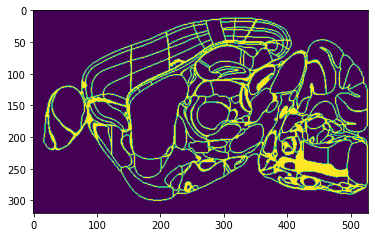

In [6]:
plt.imshow(contour_image[300, :, :])

In [7]:
itk.imwrite(contour_image, "../results/ccf-contours.nii.gz", compression=True)

In [8]:
binary_image = itk.binary_threshold_image_filter(
    contour_image,
    upper_threshold=65535,
    lower_threshold=0,
    inside_value=255,
    outside_value=0,
)

print(f"{np.min(binary_image)},{np.max(binary_image)}")
binary_image = itk.cast_image_filter(
    binary_image, ttype=[type(binary_image), itk.Image[itk.UC, 3]]
)

0.0,1.0


In [9]:
itkwidgets.view(binary_image)

<IPython.core.display.Javascript object>

In [10]:
itk.imwrite(
    binary_image, "../results/ccf-binary-contours.nii.gz", compression=True
)

## Get 2D Slice

Extract with given step size along given spatial direction.

In [11]:
def get_bounds(image, transform=None):
    """Get the physical boundaries of the space sampled by the ITK image.
    Each voxel in an ITK image is considered to be a sample of the spatial
    volume occupied by that voxel taken at the spatial center of the volume.
    The physical point returned at each discrete voxel coordinate is
    considered to be the physical location of the sample point. We adjust by
    half a voxel in each direction to get the bounds of the space sampled
    by the image.
    """
    HALF_VOXEL_STEP = 0.5
    dimension = image.GetImageDimension()
    lower_index = itk.ContinuousIndex[itk.D, dimension]()
    lower_index.Fill(-1 * HALF_VOXEL_STEP)
    upper_index = itk.ContinuousIndex[itk.D, dimension]()
    for dim in range(dimension):
        upper_index.SetElement(dim, itk.size(image)[dim] + HALF_VOXEL_STEP)

    image_bounds = [
        image.TransformContinuousIndexToPhysicalPoint(lower_index),
        image.TransformContinuousIndexToPhysicalPoint(upper_index),
    ]
    return (
        [transform.TransformPoint(pt) for pt in image_bounds]
        if transform
        else image_bounds
    )


print(
    f"Contour image occupies physical space on these bounds: {get_bounds(binary_image)}"
)

Contour image occupies physical space on these bounds: [itkPointD3 ([0.0125, -0.0125, 0.0125]), itkPointD3 ([-11.4125, 13.2125, -8.0125])]


In [12]:
def get_slice(
    image: itk.Image[itk.F, 3],
    extract_spatial_dimension: int,
    extract_offset: float,
    verbose=False,
) -> itk.Image[itk.UC, 2]:
    """Extract an image slice given a physical axis and offset along the axis.
    Assumes image is anatomically aligned; that is, the orientation matrix represents
    a series of 90-degree rotations.
    """

    # Get the voxel axis to use
    test_point = [0] * 3
    test_point[extract_spatial_dimension] = 1
    voxel_aligned_axis = np.absolute(
        np.matmul(test_point, np.array(binary_image.GetDirection()))
    )
    extract_voxel_dimension = int(np.argmax(voxel_aligned_axis))

    output_size = itk.size(image)
    output_size[extract_voxel_dimension] = 0

    requested_position = [0] * 3
    requested_position[extract_spatial_dimension] = extract_offset
    output_index = image.TransformPhysicalPointToIndex(requested_position)

    if verbose:
        print(f"Extract: start {output_index}, size {output_size}")

    extract_filter = itk.ExtractImageFilter[
        type(image), itk.Image[itk.UC, 2]
    ].New()
    extract_filter.SetInput(image)
    extract_filter.SetExtractionRegion(
        itk.ImageRegion[3](output_index, output_size)
    )
    extract_filter.SetDirectionCollapseToStrategy(
        itk.ExtractImageFilterEnums.DirectionCollapseStrategy_DIRECTIONCOLLAPSETOGUESS
    )
    extract_filter.Update()

    return extract_filter.GetOutput()

In [13]:
start_index = [
    0
] * 3  # First possible extraction index is in the center of the first pixel
end_index = [
    int(el) for el in np.array(itk.size(binary_image)) - np.ones(3)
]  # Last possible extraction index is in center of the last pixel

image_bounds = [
    binary_image.TransformIndexToPhysicalPoint(start_index),
    binary_image.TransformIndexToPhysicalPoint(end_index),
]

extracted_images = []
for physical_offset in np.arange(
    np.min([image_bounds[0][0], image_bounds[1][0]]),
    np.max([image_bounds[0][0], image_bounds[1][0]]),
    SLICE_STEP_SIZE,
):
    extracted_images.append(
        get_slice(binary_image, SLICE_PHYSICAL_AXIS, physical_offset)
    )

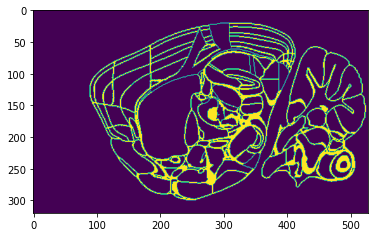

In [14]:
plt.imshow(extracted_images[32])

In [15]:
os.makedirs(RESULTS_PATH, exist_ok=True)
for slice_index, extracted_image in enumerate(extracted_images):
    itk.imwrite(
        extracted_image,
        f"{RESULTS_PATH}/contour{slice_index}.png",
        compression=True,
    )
    itk.imwrite(
        extracted_image,
        f"{RESULTS_PATH}/contour{slice_index}.mhd",
        compression=True,
    )